In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from perspective import CalibratedPerception
from object_detect import segment_navigable
from object_detect import segment_rock_sample
from rover_state import RoverState
from collections import namedtuple
from perception import render_particles
from ray_detect import particle_to_rays
from geometry import to_polar_coords

In [2]:
img = plt.imread('../test_dataset/IMG/robocam_2017_05_02_11_16_21_421.jpg')

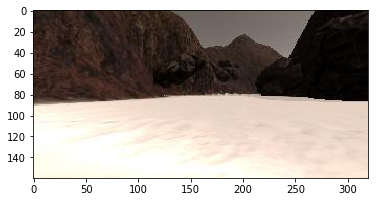

In [4]:
perception = CalibratedPerception()

In [5]:
df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

In [48]:
def next_state():
    idx = np.random.randint(0, len(df['Path']))
    ret = RoverState()
    ret.img = plt.imread(df['Path'][idx])
    ret.pos = (df["X_Position"][idx], df["Y_Position"][idx])
    ret.yaw = df['Yaw'][idx]
    ret.roll = df['Roll'][idx]
    ret.pitch = df['Pitch'][idx]
    return ret

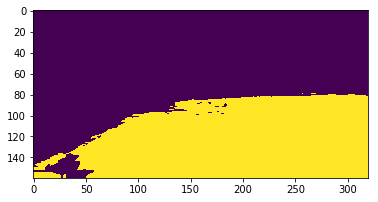

In [103]:
state = next_state()
state.img = plt.imread('../calibration_images/ex')
navigable = segment_navigable(state.img)
plt.imshow(navigable)
plt.show()

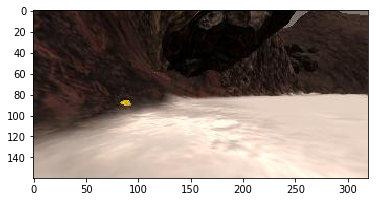

In [105]:
plt.imshow(state.img)
plt.show()

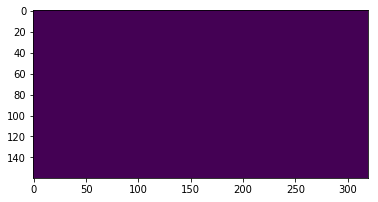

In [106]:
rock = segment_rock_sample(state.img)
plt.imshow(rock)
plt.show()

In [107]:
w_coords, b_coords = perception.evaluate(navigable, state)

In [108]:
ret = render_particles(b_coords)

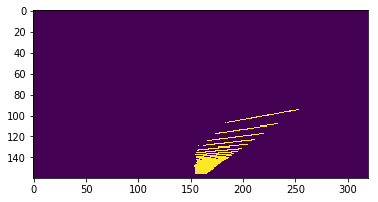

In [109]:
plt.imshow(ret)
plt.show()

In [110]:
r, theta = to_polar_coords(b_coords[0], b_coords[1])

In [111]:
from mesh_cluster import cluster_on_mesh


VIEW_ANGLE = np.pi / 3
NUM_RAY_MESH = 240


def interpolate_ray(
    angle, dists, focal_length, focal_height, interval):

  # projection ray to 2D plane
  focal_length = focal_length / np.cos(angle)

  proj_ratio = dists / (dists + focal_length)
  proj_dists = focal_height * proj_ratio
  print('project_dim', proj_dists.min(), proj_dists.max())
  # find gap by mesh in projection
  # mesh cluster the projected dists

  clusters = cluster_on_mesh(proj_dists, interval=interval)

  ret = []
  for cluster in clusters:
    start, end = dists[cluster].min(), dists[cluster].max()
    ret.append((start, end))
  print('num_segs:', len(ret))
  return np.array(ret)


In [112]:
FOCAL_LENGTH = 5
FOCAL_HEIGHT = 10
INTERVAL = 0.3


class Ray(object):

  def __init__(self, theta, dists):
    self.theta = theta
    segments = interpolate_ray(
      theta, dists, FOCAL_LENGTH, FOCAL_HEIGHT, INTERVAL)
    self.segments = segments


def particle_to_rays(
    dists, angles, max_angle, min_dist, max_dist):

  angle_idx = np.logical_and(angles > -max_angle, angles < max_angle)
  dist_idx = np.logical_and(dists > min_dist, dists < max_dist)
  idx = np.logical_and(angle_idx, dist_idx)

  dists, angles = dists[idx], angles[idx]

  proposals = np.linspace(
    -max_angle, max_angle, NUM_RAY_MESH + 1)

  angular_delta = np.abs(proposals[:, None] - angles[None, :])

  interval = 2.0 * VIEW_ANGLE / NUM_RAY_MESH
  votes = angular_delta < interval

  ret = []
  for i in range(NUM_RAY_MESH):
    vote_dist = dists[votes[i, :]]
    if len(vote_dist) <= 1:
      continue
    print('vote_dims:', proposals[i], vote_dist.min(), vote_dist.max(), len(vote_dist))
    ret.append(Ray(proposals[i], vote_dist))

  return ret


In [113]:
rays = particle_to_rays(r, theta, np.pi/3, min_dist=0.5, max_dist=9.8)

vote_dims: -0.951204442337 7.32299646116 8.9493252833 5
project_dim 4.59604676224 5.09654877978
num_segs: 1
vote_dims: -0.942477796077 5.42463737837 8.9493252833 16
project_dim 3.89389185061 5.12683931797
num_segs: 1
vote_dims: -0.933751149817 4.32016757473 8.78930412556 27
project_dim 3.39474818619 5.1114961996
num_segs: 1
vote_dims: -0.925024503557 3.33833636091 8.63180015235 38
project_dim 2.86637679667 5.09551340919
num_segs: 1
vote_dims: -0.916297857297 2.89950496994 8.47680088943 49
project_dim 2.6091336678 5.0789094037
num_segs: 1
vote_dims: -0.907571211037 2.56684034118 8.37485408895 60
project_dim 2.40156767915 5.07683825871
num_segs: 1
vote_dims: -0.898844564777 2.30601861543 8.22400580529 70
project_dim 2.23063254233 5.05907566065
num_segs: 1
vote_dims: -0.890117918517 2.0960714373 8.07563651878 79
project_dim 2.08748143395 5.04074658095
num_segs: 1
vote_dims: -0.881391272257 1.84819396149 9.7555661778 94
project_dim 1.90361535937 5.53782711349
num_segs: 1
vote_dims: -0.8726

/Users/pu/work/PycharmProjects/RoboND-Rover-Project/code/mesh_cluster.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  interval = (max_val - min_val) / bins


In [114]:
len(rays)

191